In [1]:
import argparse
import pathlib
import random
import sys
from typing import Dict, Any, List

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from figure_reliability_diagrams import plot_bayesian_reliability_diagram

sys.path.insert(0, '..')
from data_utils import DATAFILE_LIST, prepare_data, FIGURE_DIR, CIFAR100_CLASSES
from models import SumOfBetaEce

import matplotlib;matplotlib.rcParams['font.size'] = 10
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'

LINEWIDTH = 13.97
LOG_FREQ = 10

In [89]:
num_bins = 10
pseudocount = 2
N_list = [100, 1000, 10000]
num_samples = 10000
BOOTSTRAP = False


PRECOMPUTED_GROUND_TRUTH_ECE = {
    'cifar100': 0.09869599923480106,
    'imagenet': 0.05007696763512674,
    'svhn': 0.01095047338003833,
    '20newsgroup': 0.09242892818137771,
    'dbpedia': 0.002903918643656106,
}

In [94]:
def plot_ece_samples(ax: mpl.axes.Axes,
                     ground_truth_ece: float,
                     frequentist_ece,
                     samples_posterior,
                     xrange):
    if isinstance(frequentist_ece, float):
        ax.axvline(x=frequentist_ece, label='Frequentist', color='blue', linewidth=4)
    else:
        ax.hist(frequentist_ece, color='blue', alpha=0.7, label='Frequentist', bins=30)
    ax.hist(samples_posterior, color='red', label='Bayesian', alpha=0.7, bins=30)
    ax.axvline(x=ground_truth_ece, label='Ground truth', color='black', linestyle='--', linewidth=4)
    ax.set_xlim(xrange[0], xrange[1])
    return ax


def frequentist_bootstrap_ece(confidences: List[int], observations: List[bool], num_bootstrap_samples: int):
    frequentist_ece = np.zeros(num_bootstrap_samples, )
    num_datapoints = len(confidences)
    for idx in range(num_bootstrap_samples):
        indices = np.random.choice(np.arange(num_datapoints), size=num_datapoints, replace=True)
        confidences_resampled = [confidences[i] for i in indices]
        observations_resampled = [observations[i] for i in indices]
        ece_model = SumOfBetaEce(num_bins=10, pseudocount=1e-6)
        ece_model.update_batch(confidences_resampled, observations_resampled)
        frequentist_ece[idx] = ece_model.frequentist_eval
    return frequentist_ece

No handles with labels found to put in legend.
No handles with labels found to put in legend.
/Users/disiji/Dropbox/current/bayesian-blackbox/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


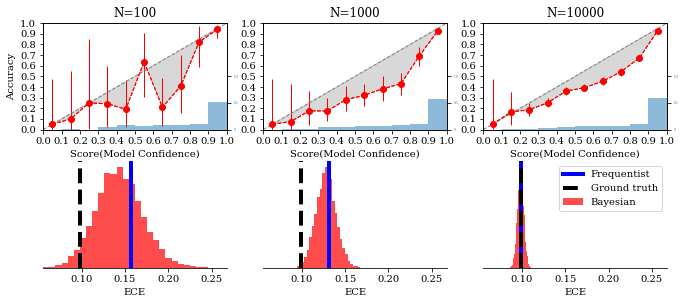

In [105]:
dataset = 'cifar100'
datafile = DATAFILE_LIST[dataset]
categories, observations, confidences, idx2category, category2idx, labels = prepare_data(datafile, False)
tmp = list(zip(confidences, observations))
random.shuffle(tmp)
confidences, observations = zip(*tmp)
ece_model = SumOfBetaEce(num_bins=10, pseudocount=pseudocount)

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(LINEWIDTH * 0.8, 4.5),
                        gridspec_kw = {'wspace':0.2, 'hspace':0.3})

for i in range(len(N_list)):
    
    tmp = 0 if i == 0 else N_list[i - 1]
    ece_model.update_batch(confidences[tmp: N_list[i]], observations[tmp: N_list[i]])
    samples_posterior = ece_model.sample(num_samples)
    if i == 0:
        xrange = (samples_posterior.min(), samples_posterior.max())

    if BOOTSTRAP:
        file = pathlib.Path(FIGURE_DIR + 'frequentist_ece_%d.csv' % i)
        if file.exists():
            frequentist_ece = np.genfromtxt(file)
        else:
            frequentist_ece = frequentist_bootstrap_ece(confidences[:N_list[i]], observations[:N_list[i]],num_samples)
            np.savetxt(file, frequentist_ece, delimiter=',')
    else:
        frequentist_ece = ece_model.frequentist_eval

    ground_truth_ece = PRECOMPUTED_GROUND_TRUTH_ECE[dataset]

    axes[0, i] = plot_bayesian_reliability_diagram(axes[0, i], ece_model)
    axes[0, 0].set_ylabel("Accuracy", fontsize=10)
    axes[0, i].set_xlabel("Score(Model Confidence)", fontsize=10)
    axes[0, i].set_title("N=%d" % N_list[i])
    
    axes[1, i] = plot_ece_samples(axes[1, i], ground_truth_ece, frequentist_ece, samples_posterior, xrange)
    axes[1, i].tick_params(left=False)
    axes[1, i].tick_params(labelleft=False)
    axes[1, i].set_xlabel("ECE")
    axes[1, -1].legend()
    
    axes[1, i].spines['left'].set_visible(False)
    axes[1, i].spines['right'].set_visible(False)
    axes[1, i].spines['top'].set_visible(False)

fig.tight_layout()

In [106]:
fig.savefig(FIGURE_DIR + 'cifar100_ece_posterior.pdf', bbox_inches='tight', pad_inches=0)